## LSTM 예측

### 055550.KS

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# 데이터 로드
stock_data = pd.read_csv('055550.KS.csv')
original_close = stock_data['Close'].values
dates = pd.to_datetime(stock_data['Date'])

# 필요한 컬럼만 선택
cols = list(stock_data)[1:6]
stock_data = stock_data[cols].astype(float)

In [24]:
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

In [25]:
n_train = int(0.8*stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = dates[n_train:]

In [26]:
pred_days = 1  # prediction period
seq_len = 50   # sequence length = past days for future prediction.
input_dim = 5  # input_dimension = ['Close', 'Volume']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [27]:
# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# 학습률 설정
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# EarlyStopping과 ModelCheckpoint 설정
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('./save_weights/055550.KS_lstm_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

모델을 찾을 수 없습니다, 모델을 처음부터 학습합니다.
Epoch 1/100
134/134 [==============================] - 13s 57ms/step - loss: 0.0837 - val_loss: 0.0065
Epoch 2/100
  2/134 [..............................] - ETA: 6s - loss: 0.0120

C:\Users\cho03\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 6s 48ms/step - loss: 0.0097 - val_loss: 0.0053
Epoch 3/100
134/134 [==============================] - 7s 52ms/step - loss: 0.0081 - val_loss: 0.0045
Epoch 4/100
134/134 [==============================] - 6s 47ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 5/100
134/134 [==============================] - 8s 63ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 6/100
134/134 [==============================] - 8s 56ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 7/100
134/134 [==============================] - 6s 47ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/100
134/134 [==============================] - 7s 49ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 9/100
134/134 [==============================] - 6s 47ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 10/100
134/134 [==============================] - 6s 48ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 11/100
134/134 [==============================] - 7s 50ms/step - loss: 0.0031 - val_los

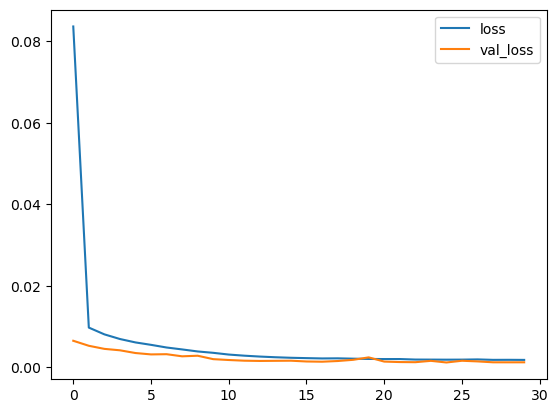

In [29]:
# 모델 불러오기 혹은 학습
try:
    model = load_model('./save_weights/055550.KS_lstm_best_model.h5')
    print("디스크에서 모델을 불러왔습니다.")
except:
    print("모델을 찾을 수 없습니다, 모델을 처음부터 학습합니다.")
    history = model.fit(trainX, trainY, epochs=100, batch_size=32,
                    validation_split=0.1, verbose=1, callbacks=[es, mc])

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [30]:
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

36/36 [==============================] - 2s 33ms/step
(1150, 1) (1150, 1)


In [31]:
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

(1150,)


In [32]:
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

(1150,)


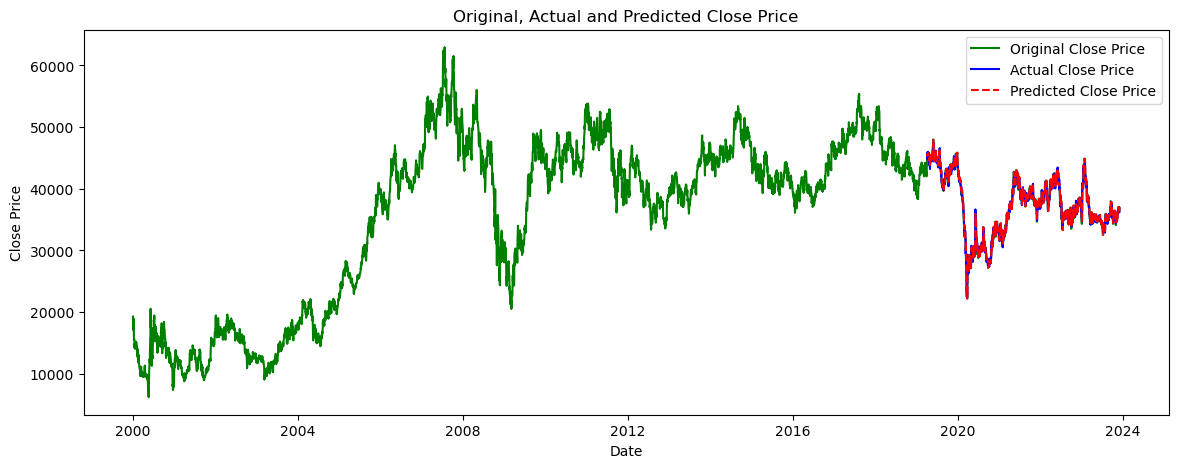

In [34]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_close, color='green', label='Original Close Price')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Close Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Original, Actual and Predicted Close Price')
plt.legend()
plt.show()


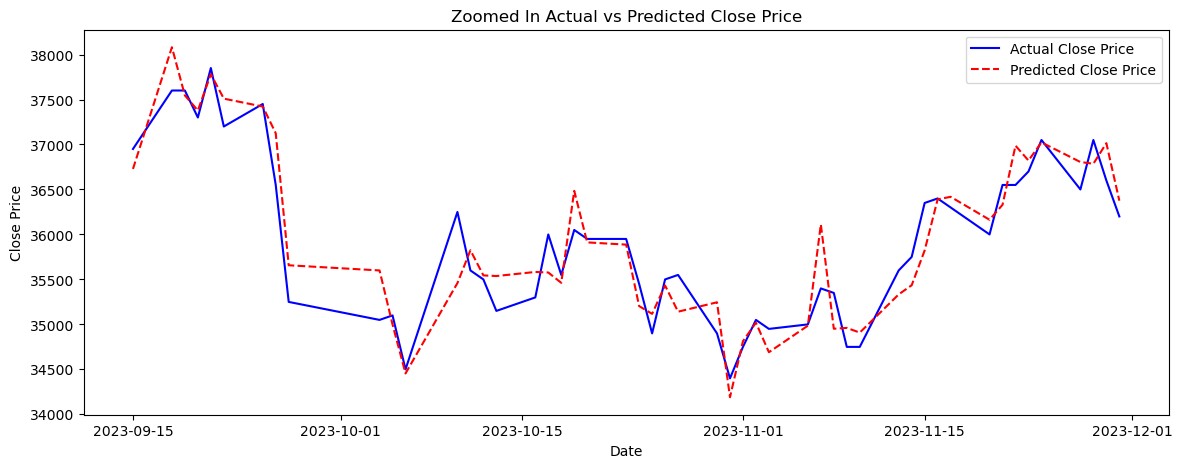

In [35]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Close Price')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Close Price')  # 라벨 이름 변경

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Zoomed In Actual vs Predicted Close Price')
plt.legend()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(testY_original, y_pred)
mae = mean_absolute_error(testY_original, y_pred)

print(f"모델의 예측 결과 평가: MSE = {mse:.2f}, MAE = {mae:.2f}")

모델의 예측 결과 평가: MSE = 153369.40, MAE = 279.74


In [17]:
# 가장 최근 50일의 데이터로 1일 후 종가 예측
recent_data_scaled = stock_data_scaled[-seq_len:]
recent_data_scaled = np.expand_dims(recent_data_scaled, 0)
predicted_price_scaled = model.predict(recent_data_scaled)

# 예측 결과를 원래 스케일로 변환
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], predicted_price_scaled.shape[0], axis=0)
mean_values_pred[:, 0] = np.squeeze(predicted_price_scaled)
predicted_price = scaler.inverse_transform(mean_values_pred)[:,0]

print(f"1일 후의 예측 종가: {predicted_price}")

1/1 [==============================] - 0s 81ms/step
1일 후의 예측 종가: [36630.82806175]
